In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import os
import csv
from datetime import datetime
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Models Estimation

In [4]:
path = '/content/drive/MyDrive/Virtual env/z_inhomogenous_modeling/silicon_pad_all_data/'
print(len(sorted(os.listdir(path))))
rnd_idx = np.array([2,10,25,40,48,59,73,79,85,88,101,110,125,128,132,139,144,148,167,174,189])
len(rnd_idx)

800


21

In [5]:
y = np.array(pd.read_csv(path+f'{rnd_idx[0]}_percep_force_silicon_pad_data.csv'))
x = np.array(pd.read_csv(path+f'{rnd_idx[0]}_percep_pos_silicon_pad_data.csv'))
l = len(y)
x.shape, y.shape

((872, 12), (872, 1))

In [6]:
for i in range(len(rnd_idx)-1):
    x1 = np.array(pd.read_csv(path+f'{rnd_idx[i+1]}_percep_pos_silicon_pad_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{rnd_idx[i+1]}_percep_force_silicon_pad_data.csv'))

    x = np.concatenate([x,x1])
    y = np.concatenate([y,y1])
print(x.shape, y.shape)

(18661, 12) (18661, 1)


In [7]:
y_test = np.array(pd.read_csv(path+f'{rnd_idx[3]-2}_force_silicon_pad_data.csv'))
x_test = np.array(pd.read_csv(path+f'{rnd_idx[3]-2}_pos_silicon_pad_data.csv'))

x_test.shape, y_test.shape

((34488, 12), (34488, 1))

In [8]:
for i in range(len(rnd_idx)//2):
    x1 = np.array(pd.read_csv(path+f'{rnd_idx[i+1]-1}_pos_silicon_pad_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{rnd_idx[i+1]-1}_force_silicon_pad_data.csv'))
    x_test = np.concatenate([x_test,x1])
    y_test = np.concatenate([y_test,y1])
print(x_test.shape, y_test.shape)

(379380, 12) (379380, 1)


In [ ]:
cat = CatBoostRegressor()
t1 = datetime.now()
cat.fit(x,y)
t2 = datetime.now()
y_pred = cat.predict(x_test)

In [10]:
print('RMSE:', mean_squared_error(y_pred, y_test)**0.5)
print(t2-t1)

RMSE: 0.09952145418871156
0:00:09.584236


In [ ]:
error = []
for i in range(1,201):
    x1 = np.array(pd.read_csv(path+f'{i}_pos_silicon_pad_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_silicon_pad_data.csv'))
    y_pred = cat.predict(x1)
    statement = f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}\n'
    #print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')
    error.append(mean_squared_error(y_pred, y1)**0.5)
    with open('results_catboost.txt','a') as f:
        f.write(statement)
print(sum(error)/len(error))

0.12500280431555594


In [ ]:
print(np.std(np.array(error)))
max(error), min(error)

0.07549028233586641


(0.42694936506663106, 0.04986136517404884)

In [ ]:
for i in range(5):
    val = sorted(error)[::-1][i]
    print(val, 'at', error.index(val)+1)


0.42694936506663106 at 149
0.3741043460383621 at 20
0.34965485450610906 at 127
0.34387360988601984 at 116
0.3436145898195095 at 29


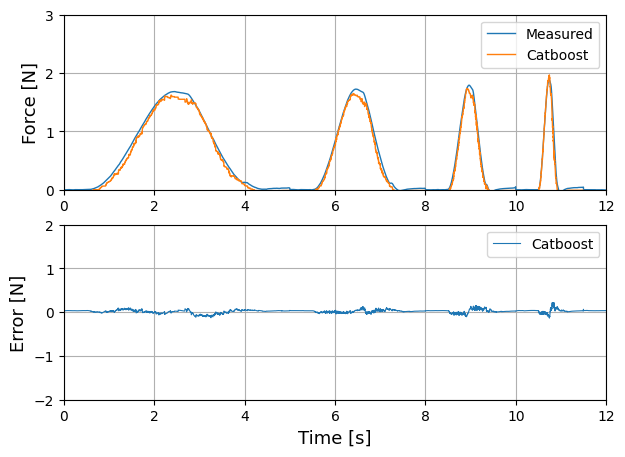

In [21]:
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings('ignore')

i = 2
x1 = np.array(pd.read_csv(path+f'{i}_pos_silicon_pad_data.csv')) # fractional derivatives
y1 = np.array(pd.read_csv(path+f'{i}_force_silicon_pad_data.csv'))
y_pred = cat.predict(x1)
error_cat = []
for j in range(len(y1)-5):
    error_cat.append(y1[j,0]-y_pred[j])

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(5)
fig.set_figwidth(7)

ax1.plot(np.arange(0,12,0.001),y_test[:12000],label = 'Measured',linewidth=1.0)
#ax1.plot(np.arange(0,12,0.001),y1_pred[:12000],label = 'Random Forest',linewidth=0.8)
ax1.plot(np.arange(0,12,0.001),y_pred[:12000],label = 'Catboost',linewidth=1.0)
ax1.legend(loc = 'upper right')
ax1.set_xlim([0, 12])
ax1.set_ylim([0, int(max(y_pred[:12000])+2)])
ax1.set_ylabel('Force [N]',fontsize=13)
#ax1.set_xlabel('Time [s]',fontsize=13)
ax1.grid()

ax2.plot(np.arange(0,12,0.001),error_cat[:12000],label = 'Catboost',linewidth=0.8)
ax2.legend(loc = 'upper right')
ax2.set_xlim([0, 12])
ax2.set_ylim([-2, 2])
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_ylabel('Error [N]',fontsize=13)
ax2.set_xlabel('Time [s]',fontsize=13)
ax2.grid()

plt.savefig(f'obj5_measured_pred_{i}.eps')
plt.show()

# Random Forest

In [14]:
rf = RandomForestRegressor()
t1 = datetime.now()
rf.fit(x,y)
t2 = datetime.now()
y_pred = rf.predict(x_test)
print('RMSE:', mean_squared_error(y_pred, y_test)**0.5)
print(t2-t1)

RMSE: 0.10500591993339117
0:00:29.494232


In [ ]:
error = []
for i in range(1,201):
    x1 = np.array(pd.read_csv(path+f'{i}_pos_silicon_pad_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_silicon_pad_data.csv'))
    y_pred = rf.predict(x1)
    statement = f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}\n'
    #print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')
    error.append(mean_squared_error(y_pred, y1)**0.5)
    with open('results_RF.txt','a') as f:
        f.write(statement)
print(sum(error)/len(error))

In [ ]:
print(sum(error)/len(error))
print(np.std(np.array(error)))
max(error), min(error)

0.13371617356335128
0.07897814785819778


(0.5007825904504905, 0.05752255642067074)

# Clusterring

In [15]:
path2 = '/content/drive/MyDrive/Virtual env/z_inhomogenous_modeling/'
arr = np.array(pd.read_csv(path2+'x_y_silicon_pad.csv', names = ['x','y']))
print(arr.shape)
arr[:5]

(200, 2)


array([[ -0.427,  -9.475],
       [ -0.475,   8.082],
       [ -0.583,   0.632],
       [ -0.859,  -1.168],
       [ -1.187, -10.809]])

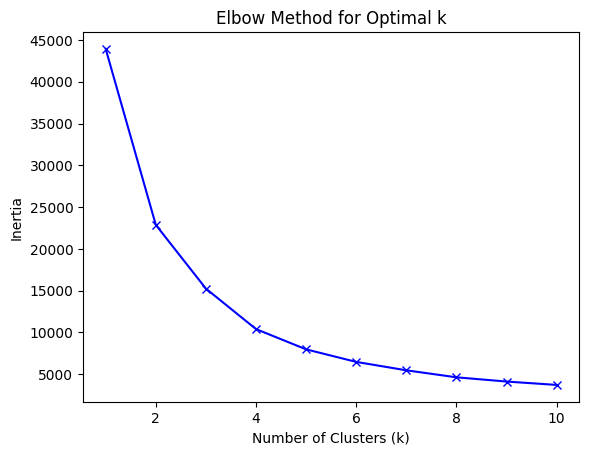

In [16]:
from sklearn.cluster import KMeans
k_values = range(1, 11)

# Perform k-means clustering for each k value
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(arr)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values against the number of clusters
plt.plot(k_values, inertia_values, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [17]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(arr)
kmeans.cluster_centers_

array([[  8.55160606, -13.51512121],
       [ -8.6122963 ,   9.47033333],
       [  6.1935122 ,  14.12065854],
       [ -8.30161111, -11.42472222],
       [  7.43463889,  -0.29452778]])

In [18]:
from collections import defaultdict
d = defaultdict(lambda: [])
for i in range(200):
    label = kmeans.predict([arr[i]])[0]
    d[label].append(i)

for i in range(5):
    print(d[i])

[97, 100, 113, 116, 119, 122, 125, 127, 130, 133, 137, 138, 141, 142, 145, 149, 151, 158, 164, 165, 166, 168, 170, 173, 175, 177, 180, 184, 185, 187, 193, 195, 198]
[1, 5, 9, 11, 14, 15, 16, 19, 22, 23, 24, 25, 30, 32, 33, 35, 37, 38, 39, 41, 42, 43, 46, 50, 51, 53, 54, 55, 56, 57, 58, 60, 62, 65, 68, 69, 70, 71, 72, 74, 75, 77, 78, 79, 81, 82, 83, 84, 86, 88, 89, 90, 91, 93]
[7, 8, 52, 95, 98, 99, 102, 103, 105, 106, 107, 110, 111, 112, 115, 120, 121, 124, 126, 128, 129, 132, 136, 143, 147, 148, 150, 152, 154, 160, 161, 162, 167, 178, 179, 183, 186, 191, 192, 196, 199]
[0, 4, 6, 10, 12, 13, 17, 18, 20, 21, 26, 27, 28, 29, 31, 34, 36, 40, 44, 45, 47, 48, 49, 59, 61, 63, 64, 66, 67, 73, 76, 80, 85, 87, 92, 96]
[2, 3, 94, 101, 104, 108, 109, 114, 117, 118, 123, 131, 134, 135, 139, 140, 144, 146, 153, 155, 156, 157, 159, 163, 169, 171, 172, 174, 176, 181, 182, 188, 189, 190, 194, 197]


In [19]:
from scipy.linalg import norm

def dist(i):
    at = -1
    mini = 10
    for j in range(len(d[i])):
        dis = ((arr[d[i][j]][0]- kmeans.cluster_centers_[i][0])**2 + (arr[d[i][j]][1]- kmeans.cluster_centers_[i][1])**2)**0.5
        if dis <mini:
            mini = dis
            at = j
    print(f'{d[i][at]+1} is the master node of {i}th cluster')
    print(arr[d[i][at]], kmeans.cluster_centers_[i],'\n')
for i in range(5):
    dist(i)

196 is the master node of 0th cluster
[  8.905 -11.94 ] [  8.55160606 -13.51512121] 

10 is the master node of 1th cluster
[-10.231   9.415] [-8.6122963   9.47033333] 

168 is the master node of 2th cluster
[ 5.789 14.423] [ 6.1935122  14.12065854] 

88 is the master node of 3th cluster
[ -9.235 -11.41 ] [ -8.30161111 -11.42472222] 

189 is the master node of 4th cluster
[7.99  0.432] [ 7.43463889 -0.29452778] 



In [20]:
x1 = np.array(pd.read_csv(path+f'{10}_pos_silicon_pad_data.csv'))[:,:10] # fractional derivatives
y1 = np.array(pd.read_csv(path+f'{10}_force_silicon_pad_data.csv'))
rf1 = RandomForestRegressor()
rf1.fit(x1,y1)

RandomForestRegressor()

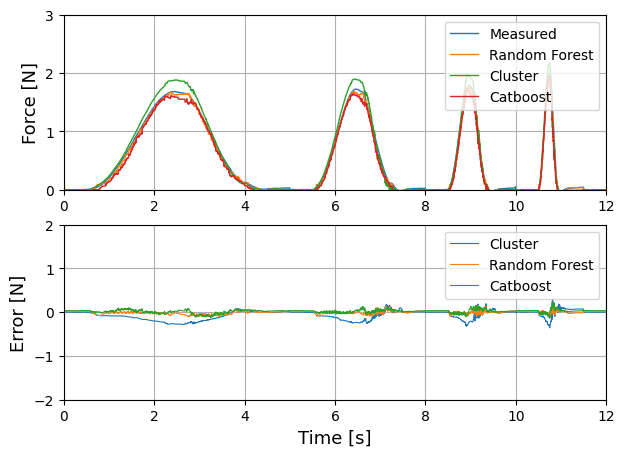

In [24]:
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings('ignore')

i = 2
x1 = np.array(pd.read_csv(path+f'{i}_pos_silicon_pad_data.csv')) # fractional derivatives
y1 = np.array(pd.read_csv(path+f'{i}_force_silicon_pad_data.csv'))
y_pred = cat.predict(x1)
y_rf = rf.predict(x1)
y_cluster = rf1.predict(x1[:,:10])

error_cat = []
error_rf = []
error_cluster = []
for j in range(len(y1)-5):
    error_cat.append(y1[j,0]-y_pred[j])
    error_rf.append(y1[j,0]-y_rf[j])
    error_cluster.append(y1[j,0]-y_cluster[j])


fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(5)
fig.set_figwidth(7)

ax1.plot(np.arange(0,12,0.001),y_test[:12000],label = 'Measured',linewidth=1.0)
ax1.plot(np.arange(0,12,0.001),y_rf[:12000],label = 'Random Forest',linewidth=1.0)
ax1.plot(np.arange(0,12,0.001),y_cluster[:12000],label = 'Cluster',linewidth=1.0)
ax1.plot(np.arange(0,12,0.001),y_pred[:12000],label = 'Catboost',linewidth=1.0)

ax1.legend(loc = 'upper right')
ax1.set_xlim([0, 12])
ax1.set_ylim([0, int(max(y_pred[:12000])+2)])
ax1.set_ylabel('Force [N]',fontsize=13)
#ax1.set_xlabel('Time [s]',fontsize=13)
ax1.grid()

ax2.plot(np.arange(0,12,0.001),error_cluster[:12000],label = 'Cluster',linewidth=0.8)
ax2.plot(np.arange(0,12,0.001),error_rf[:12000],label = 'Random Forest',linewidth=0.8)
ax2.plot(np.arange(0,12,0.001),error_cat[:12000],label = 'Catboost',linewidth=0.8)

ax2.legend(loc = 'upper right')
ax2.set_xlim([0, 12])
ax2.set_ylim([-2, 2])
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_ylabel('Error [N]',fontsize=13)
ax2.set_xlabel('Time [s]',fontsize=13)
ax2.grid()

plt.savefig(f'obj5_measured_pred_{i}_all.eps')
plt.show()

In [ ]:
x1 = np.array(pd.read_csv(path+f'{10}_pos_silicon_pad_data.csv'))[:,:10] # fractional derivatives
y1 = np.array(pd.read_csv(path+f'{10}_force_silicon_pad_data.csv'))
rf = RandomForestRegressor()
rf.fit(x1,y1)

error = []
array = np.array(d[0])+1
for i in array:
    x2 = np.array(pd.read_csv(path+f'{i}_pos_silicon_pad_data.csv'))[:,:10] # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_silicon_pad_data.csv'))
    y_pred = rf.predict(x2)
    statement = f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}\n'
    #print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')
    error.append(mean_squared_error(y_pred, y1)**0.5)
    with open('cluster.txt','a') as f:
        f.write(statement)
print(sum(error)/len(error))
print(max(error), min(error))
total = error

0.18916528445452746
0.37279006505693363 0.01659050799701343


In [ ]:
x1 = np.array(pd.read_csv(path+f'{196}_pos_silicon_pad_data.csv'))[:,:10] # fractional derivatives
y1 = np.array(pd.read_csv(path+f'{196}_force_silicon_pad_data.csv'))
rf = RandomForestRegressor()
rf.fit(x1,y1)

error = []
array = np.array(d[1])+1
for i in array:
    x2 = np.array(pd.read_csv(path+f'{i}_pos_silicon_pad_data.csv'))[:,:10] # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_silicon_pad_data.csv'))
    y_pred = rf.predict(x2)
    statement = f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}\n'
    #print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')
    error.append(mean_squared_error(y_pred, y1)**0.5)
    with open('cluster.txt','a') as f:
        f.write(statement)
print(sum(error)/len(error))
print(max(error), min(error))
total += error

0.08251595601889383
0.21063656609222672 0.01433658964882802


In [ ]:
x1 = np.array(pd.read_csv(path+f'{168}_pos_silicon_pad_data.csv'))[:,:10] # fractional derivatives
y1 = np.array(pd.read_csv(path+f'{168}_force_silicon_pad_data.csv'))
rf = RandomForestRegressor()
rf.fit(x1,y1)

error = []
array = np.array(d[2])+1
for i in array:
    x2 = np.array(pd.read_csv(path+f'{i}_pos_silicon_pad_data.csv'))[:,:10] # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_silicon_pad_data.csv'))
    y_pred = rf.predict(x2)
    statement = f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}\n'
    #print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')
    error.append(mean_squared_error(y_pred, y1)**0.5)
    with open('cluster.txt','a') as f:
        f.write(statement)
print(sum(error)/len(error))
print(max(error), min(error))
total += error

0.16352512901440325
0.6721373227986831 0.013572488582218429


In [ ]:
x1 = np.array(pd.read_csv(path+f'{88}_pos_silicon_pad_data.csv'))[:,:10] # fractional derivatives
y1 = np.array(pd.read_csv(path+f'{88}_force_silicon_pad_data.csv'))
rf = RandomForestRegressor()
rf.fit(x1,y1)

error = []
array = np.array(d[3])+1
for i in array:
    x2 = np.array(pd.read_csv(path+f'{i}_pos_silicon_pad_data.csv'))[:,:10] # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_silicon_pad_data.csv'))
    y_pred = rf.predict(x2)
    statement = f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}\n'
    #print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')
    error.append(mean_squared_error(y_pred, y1)**0.5)
    with open('cluster.txt','a') as f:
        f.write(statement)
print(sum(error)/len(error))
print(max(error), min(error))
total+= error

0.15337753069694432
0.35450743075622154 0.015228832459074878


In [ ]:
x1 = np.array(pd.read_csv(path+f'{189}_pos_silicon_pad_data.csv'))[:,:10] # fractional derivatives
y1 = np.array(pd.read_csv(path+f'{189}_force_silicon_pad_data.csv'))
rf = RandomForestRegressor()
rf.fit(x1,y1)

error = []
array = np.array(d[4])+1
for i in array:
    x2 = np.array(pd.read_csv(path+f'{i}_pos_silicon_pad_data.csv'))[:,:10] # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_silicon_pad_data.csv'))
    y_pred = rf.predict(x2)
    statement = f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}\n'
    #print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')
    error.append(mean_squared_error(y_pred, y1)**0.5)
    with open('cluster.txt','a') as f:
        f.write(statement)
print(sum(error)/len(error))
print(max(error), min(error))
total += error

0.09063359845012164
0.2806794533682995 0.014617109058167693


In [ ]:
print('Mean:', np.mean(np.array(total)))
print('Std:', np.std(np.array(total)))

Mean: 0.14217500245242054
Std: 0.09279746977378847


In [ ]:
max(total)

0.6721373227986831